In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cbook
from matplotlib.colors import Normalize
import seaborn as sns
from glob import glob
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics

import plotly.plotly as py
import plotly.figure_factory as ff
import plotly
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from numpy import ma

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

In [2]:
data_1 = pd.read_pickle('kickstarter.pkl')

In [3]:
data_1['city'] = [city for city in data_1['location']]

In [4]:
city = data_1.city.value_counts()

In [5]:
data_1['city'] = (np.where(data_1['location'].isin(list(city[city>1000].index)),data_1['location'],'Other'))

In [6]:
data_1.drop(columns=['location', 'country_data', 'blurb'], inplace=True)

# saved the data_1 into excel so later I will use it for Tableau visualization 

In [7]:
data_1.to_excel("Kickstarter.xlsx")

In [8]:
# Generate a mask the size of our covariance matrix
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize = (11,9))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

# Modeling:

In [ ]:
#some features have no direct relation to the campaign as a result it can be deletes. 

In [9]:
data_modeling = data_1.drop(['backers_count', 'created_at','deadline','launched_at','state_changed_at','campaign_lenght','state_suspended','state_live','state_canceled','state_failed','staff_pick_False'], axis=1)

In [10]:
data_modeling = pd.get_dummies(columns = ['sub_category'], data = data_modeling)

In [12]:
X = data_modeling.loc[:,['goal', 'length_blurb','staff_pick_True','campaign_lenght_days','sub_category_art',
       'sub_category_comics', 'sub_category_crafts', 'sub_category_dance',
       'sub_category_design', 'sub_category_fashion',
       'sub_category_film & video', 'sub_category_food', 'sub_category_games',
       'sub_category_journalism', 'sub_category_music',
       'sub_category_photography', 'sub_category_publishing',
       'sub_category_technology', 'sub_category_theater']]

y = data_modeling['state_successful']

In [13]:
data_modeling.shape

(208240, 22)

In [14]:
pickle.dump(data_1, open("kickstarter.pkl", "wb" ) )

In [15]:
# As usual, create our train/test split
# This will become particularly important as we calculate our error metrics
#Split the data 60 - 20 - 20 train/val/test

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25)

Normalized the data for KNN and SVM

In [17]:
## This step fits the Standard Scaler to the training data
## Essentially it finds the mean and standard deviation of each variable in the training set
std = MinMaxScaler()

X_train_sc = std.fit_transform(X_train)
X_val_sc = std.transform(X_val)
X_test_sc = std.transform(X_test)

/Users/fahimehkhaleghi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.



# KNN 

Run a grid search to get the best parameter for thr model!

In [17]:
ks = np.arange(2,11)
param_grid = [{'n_neighbors': ks}]


knn_grid = GridSearchCV(KNeighborsClassifier(), 
                        param_grid, 
                        cv=3, 
                        scoring='roc_auc', 
                        verbose=1, 
                        n_jobs=-1)



knn_grid.fit(X_train_sc, y_train)


best_params = knn_grid.best_params_

best_estimator = knn_grid.best_estimator_

grid_predictions = best_estimator.predict(X_test_sc)

best_cm = confusion_matrix(y_test,grid_predictions)

best_cr = classification_report(y_test,grid_predictions)

print(best_params, best_estimator, best_cm, best_cr)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 16.1min finished


{'n_neighbors': 10} KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform') [[11682  6561]
 [ 6219 17186]]               precision    recall  f1-score   support

           0       0.65      0.64      0.65     18243
           1       0.72      0.73      0.73     23405

   micro avg       0.69      0.69      0.69     41648
   macro avg       0.69      0.69      0.69     41648
weighted avg       0.69      0.69      0.69     41648



--> We got the best parametere from grid search, so fit it gain into KNN model!

In [18]:
knn_1 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [19]:
#fit it on the train set
knn_1.fit(X_train,y_train);

In [20]:
pred = knn_1.predict(X_val)

In [84]:
print(confusion_matrix(y_val,pred))

[[11190  6921]
 [ 6949 16588]]


In [78]:
print('KNN Results:')
print(classification_report(y_val,pred))
print('KNN score: %f'% knn_1.fit(X_train,y_train).score(X_val, y_val))

KNN Results:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62     18111
           1       0.71      0.70      0.71     23537

   micro avg       0.67      0.67      0.67     41648
   macro avg       0.66      0.66      0.66     41648
weighted avg       0.67      0.67      0.67     41648

KNN score: 0.666971


In [79]:
#Run it on the test set
knn_1.fit(X_test, y_test).score(X_test, y_test)

0.725076834421821

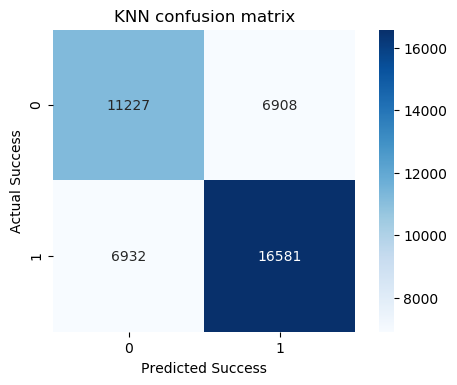

In [23]:
# Print confusion matrix for kNN
#Test set
knn_confusion = confusion_matrix(y_test, knn_1.predict(X_test))
plt.figure(dpi=100)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt = "d")

plt.xlabel('Predicted Success')
plt.ylabel('Actual Success')
plt.title('KNN confusion matrix');

In [24]:
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, knn_1.predict_proba(X_test)[:,1])
roc_auc_knn = auc(knn_fpr, knn_tpr)
print(auc(knn_fpr, knn_tpr))

0.7207779467121245


ROC AUC score =  0.7207779467121245


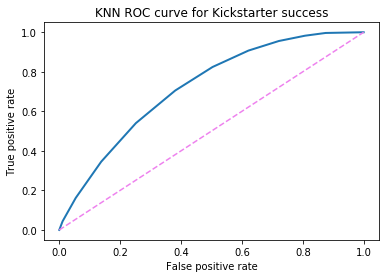

In [25]:
plt.plot(knn_fpr, knn_tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('KNN ROC curve for Kickstarter success');
print("ROC AUC score = ", roc_auc_score(y_test, knn_1.predict_proba(X_test)[:,1]))

In [26]:
# pickle.dump(open('knn_grid.pkl','rb'))

# Logit Regression

In [27]:
logit = LogisticRegression()
logit.fit(X_train, y_train)
print("The score for logistic regression is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*logit.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_test, y_test)))

/Users/fahimehkhaleghi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



The score for logistic regression is
Training:  59.81%
Test set:  59.83%


In [28]:
logit.predict(X_test)[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)

In [29]:
y_test[:10]

3811    1
1232    0
287     1
3717    0
1337    0
1356    1
293     1
2054    0
3492    0
2020    1
Name: state_successful, dtype: uint8

In [30]:
# Let's do a prediction of the first 10 observations from logistic on the test set
logit.predict_proba(X_test)[:10]

array([[0.43290448, 0.56709552],
       [0.42149301, 0.57850699],
       [0.41558996, 0.58441004],
       [0.47645891, 0.52354109],
       [0.41646838, 0.58353162],
       [0.42314305, 0.57685695],
       [0.41104931, 0.58895069],
       [0.36639514, 0.63360486],
       [0.47822742, 0.52177258],
       [0.45088418, 0.54911582]])

In [31]:
#running a grid search for Logistic Regression 
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
param_grid = dict(C=C, penalty=penalty)

logistic = LogisticRegression()
logistic_grid = GridSearchCV(logistic, param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)
logistic_grid.fit(X_train, y_train)
grid_predictions = logistic_grid.predict(X_val)
best_params = logistic_grid.best_params_
best_estimator = logistic_grid.best_estimator_
best_cm = confusion_matrix(y_val,grid_predictions)
best_cr = classification_report(y_val,grid_predictions)
print(best_params, best_estimator, best_cm, best_cr)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.8s


{'C': 21.544346900318832, 'penalty': 'l1'} LogisticRegression(C=21.544346900318832, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False) [[ 8267  9844]
 [ 3853 19684]]               precision    recall  f1-score   support

           0       0.68      0.46      0.55     18111
           1       0.67      0.84      0.74     23537

   micro avg       0.67      0.67      0.67     41648
   macro avg       0.67      0.65      0.64     41648
weighted avg       0.67      0.67      0.66     41648



[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.8s finished
/Users/fahimehkhaleghi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Now that we ran GRID search and got the best parameter, we fit it to the model again and see the result!

In [32]:
logit_1 = LogisticRegression(C=21.544346900318832, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
logit_1.fit(X_train, y_train)
print("The score for logistic regression is")
#score returns mean accuracy
print("Training: {:6.2f}%".format(100*logit_1.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*logit_1.score(X_test, y_test)))

/Users/fahimehkhaleghi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



The score for logistic regression is
Training:  67.15%
Test set:  66.80%


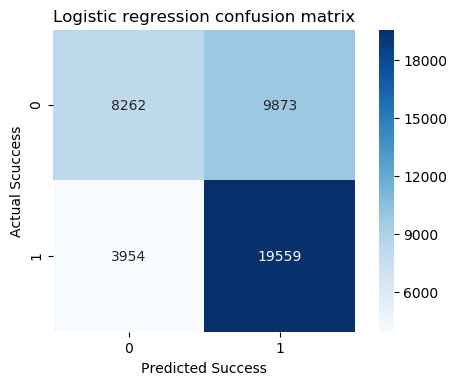

In [33]:
# Print confusion matrix for logistic regression on the test test
logit_confusion = confusion_matrix(y_test, logit_1.predict(X_test))
plt.figure(dpi=100)
sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt ='d')

plt.xlabel('Predicted Success')
plt.ylabel('Actual Scuccess')
plt.title('Logistic regression confusion matrix');

plt.savefig("confusion_matrix_logit_kickstarter")

In [34]:
logit_1.predict_proba(X_test)

array([[0.04114918, 0.95885082],
       [0.42309379, 0.57690621],
       [0.424402  , 0.575598  ],
       ...,
       [0.70079234, 0.29920766],
       [0.43948809, 0.56051191],
       [0.08741115, 0.91258885]])

In [ ]:
#The confusion matrix below ran for validation set 

In [35]:
# choose your threshold in the threshold argument:
# def make_confusion_matrix(model, threshold=0.08):
#     y_predict = (model.predict_proba(X_val)[:, 1] >= threshold) 
    
#     confusion = confusion_matrix(y_val, y_predict)
#     plt.figure(dpi=80)
    
#     sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt=',d',
#            xticklabels=['0', '1'],
#            yticklabels=['0', '1']);
#     plt.xlabel('prediction')
#     plt.ylabel('actual')

In [36]:
# from ipywidgets import interactive, FloatSlider

# # change 'logit' below to whatever you named your model:
# interactive(lambda threshold: make_confusion_matrix(logit_1, threshold), threshold=(0.0,1.0,0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

ROC AUC score =  0.7174540370940989


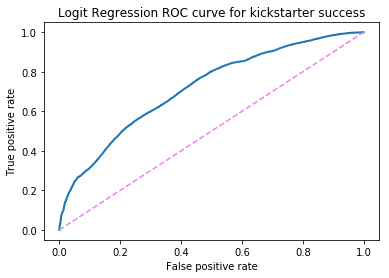

In [37]:
logit_fpr, logit_tpr, logit_thresholds = roc_curve(y_test, logit_1.predict_proba(X_test)[:,1])
roc_auc_logit = auc(logit_fpr, logit_tpr)
plt.plot(logit_fpr, logit_tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logit Regression ROC curve for kickstarter success');
print("ROC AUC score = ", roc_auc_score(y_test, logit_1.predict_proba(X_test)[:,1]))

# Decision Tree

In [38]:
#grid search 
max_depth = [4,5]
min_samples_split = [2,3]
min_samples_leaf = [2,3]
param_grid = dict(max_depth=max_depth, min_samples_split = min_samples_split, min_samples_leaf=min_samples_leaf )
tree = DecisionTreeClassifier()
tree_grid = GridSearchCV(tree, param_grid, cv=3, scoring='roc_auc', verbose=3, n_jobs=-1)
tree_grid.fit(X_train, y_train)
tree_grid_predictions = tree_grid.predict(X_val)
best_params = tree_grid.best_params_
best_estimator = tree_grid.best_estimator_
best_cm = confusion_matrix(y_val,tree_grid_predictions)
best_cr = classification_report(y_val,tree_grid_predictions)
print(best_params, best_estimator, best_cm, best_cr)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  24 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  19 out of  24 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.9s finished


{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2} DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') [[ 7799 10312]
 [ 2346 21191]]               precision    recall  f1-score   support

           0       0.77      0.43      0.55     18111
           1       0.67      0.90      0.77     23537

   micro avg       0.70      0.70      0.70     41648
   macro avg       0.72      0.67      0.66     41648
weighted avg       0.71      0.70      0.68     41648



In [106]:
tree = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [40]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [41]:
tree_pred = tree.predict(X_val)

In [42]:
#confusion matrix for validation set
print('Tree result:')
print(confusion_matrix(y_val,  tree_pred))

Tree result:
[[ 7799 10312]
 [ 2346 21191]]


In [43]:
print('Tree score: %f' %tree.fit(X_train, y_train).score(X_val, y_val))

Tree score: 0.696072


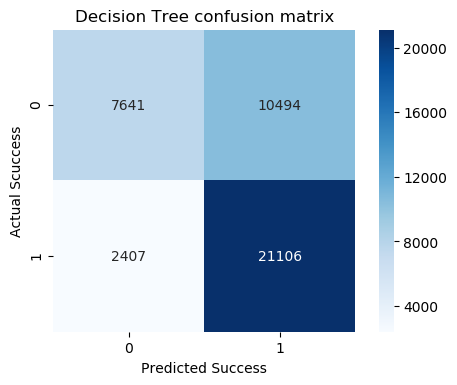

In [44]:
# Print confusion matrix for logistic regression on the test set
tree_confusion = confusion_matrix(y_test, tree.predict(X_test))
plt.figure(dpi=100)
sns.heatmap(tree_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt ='d')

plt.xlabel('Predicted Success')
plt.ylabel('Actual Scuccess')
plt.title('Decision Tree confusion matrix');

plt.savefig("confusion_matrix_Decision_Tree_kickstarter")

ROC AUC score =  0.7424632621148483


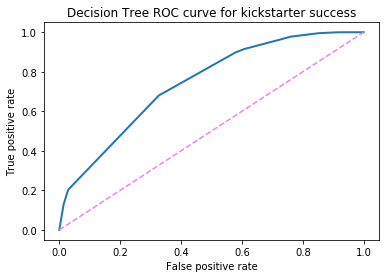

In [45]:
tree_fpr, tree_tpr, tree_thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:,1])
roc_auc_tree = auc(tree_fpr, tree_tpr)

plt.plot(tree_fpr, tree_tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Decision Tree ROC curve for kickstarter success');
print("ROC AUC score = ", roc_auc_score(y_test, tree.predict_proba(X_test)[:,1]))

In [102]:
features = list(X.columns)

In [111]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [115]:
from sklearn import tree

model = tree.DecisionTreeClassifier()

In [117]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import graphviz
from subprocess import call

clf = tree.DecisionTreeClassifier(max_depth = 2)
clf = clf.fit(X_train, y_train)

dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("Campaign Success") 

dot_data = tree.export_graphviz(clf, out_file=None, feature_names = features,
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

ExecutableNotFound: failed to execute ['dot', '-Tpdf', '-O', 'Campaign Success'], make sure the Graphviz executables are on your systems' PATH

# Random Forest

In [47]:
#grid search
forest = RandomForestClassifier()
forest_grid = GridSearchCV(forest, param_grid, cv=5, scoring='roc_auc', verbose=3, n_jobs=-1)
forest_grid.fit(X_train, y_train)
forest_grid_predictions = forest_grid.predict(X_val)
best_params = forest_grid.best_params_
best_estimator = forest_grid.best_estimator_
best_cm = confusion_matrix(y_val,forest_grid_predictions)
best_cr = classification_report(y_val,forest_grid_predictions)
print(best_params, best_estimator, best_cm, best_cr)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  31 out of  40 | elapsed:    3.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.0s finished
/Users/fahimehkhaleghi/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 3} RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) [[ 9112  8999]
 [ 3055 20482]]               precision    recall  f1-score   support

           0       0.75      0.50      0.60     18111
           1       0.69      0.87      0.77     23537

   micro avg       0.71      0.71      0.71     41648
   macro avg       0.72      0.69      0.69     41648
weighted avg       0.72      0.71      0.70     41648



In [48]:
forest_1 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [49]:
forest_1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

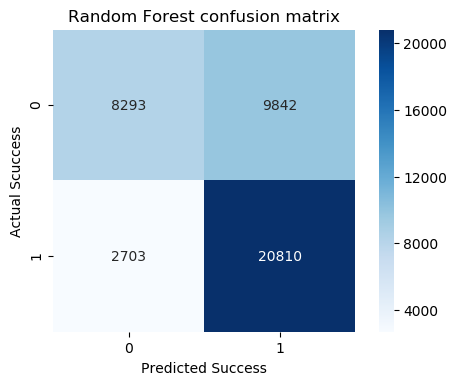

In [50]:
# Print confusion matrix for Random Forest on the test-set
forest_confusion = confusion_matrix(y_test, forest_1.predict(X_test))
plt.figure(dpi=100)
sns.heatmap(forest_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')

plt.xlabel('Predicted Success')
plt.ylabel('Actual Scuccess')
plt.title('Random Forest confusion matrix');

plt.savefig("confusion_matrix_random_forest_kickstarter")

ROC AUC score =  0.7656905610328768


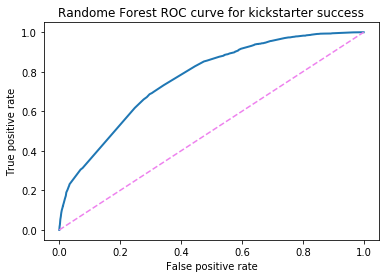

In [51]:
forest_fpr, forest_tpr, forest_thresholds = roc_curve(y_test, forest_1.predict_proba(X_test)[:,1])
roc_auc_forest = auc(forest_fpr, forest_tpr)

plt.plot(forest_fpr, forest_tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Randome Forest ROC curve for kickstarter success');
print("ROC AUC score = ", roc_auc_score(y_test, forest_1.predict_proba(X_test)[:,1]))

# Naive Bayes

# gaussian

In [60]:
gaussian = naive_bayes.GaussianNB()
bernoulli = naive_bayes.BernoulliNB()

In [61]:
gaussian.fit(X_train, y_train);

In [62]:
gaussian_pred = gaussian.predict(X_val)

In [63]:
print('Gaussian Results:')
print(confusion_matrix(y_val,gaussian_pred))
print(classification_report(y_val, gaussian_pred))
print('Gaussian score: %f' % gaussian.fit(X_train, y_train).score(X_val, y_val));

Gaussian Results:
[[  228 17883]
 [   26 23511]]
              precision    recall  f1-score   support

           0       0.90      0.01      0.02     18111
           1       0.57      1.00      0.72     23537

   micro avg       0.57      0.57      0.57     41648
   macro avg       0.73      0.51      0.37     41648
weighted avg       0.71      0.57      0.42     41648

Gaussian score: 0.569991


In [82]:
gaussian_y_score = gaussian.predict_proba(X_val)[:, 1]
gaussian_fpr, gaussian_tpr, auc_thresholds = roc_curve(y_val, gaussian_y_score)
roc_auc_gaussian = auc(gaussian_fpr, gaussian_tpr)
print(auc(gaussian_fpr, gaussian_tpr))

0.6247976654854743


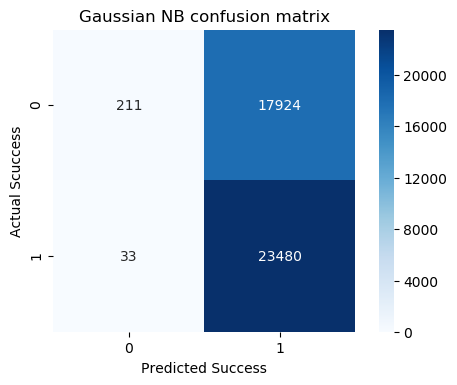

In [85]:
# Print confusion matrix on the test-set
gaussian_confusion = confusion_matrix(y_test, gaussian.predict(X_test))
plt.figure(dpi=100)
sns.heatmap(gaussian_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')

plt.xlabel('Predicted Success')
plt.ylabel('Actual Scuccess')
plt.title('Gaussian NB confusion matrix');

# plt.savefig("confusion_matrix_random_forest_kickstarter")

# bernoulli

In [86]:
bernoulli.fit(X_train, y_train);

In [87]:
bernoulli_pred = bernoulli.predict(X_val)

In [88]:
print('Bernoulli Results:')
print(confusion_matrix(y_val,bernoulli_pred))
print(classification_report(y_val, bernoulli_pred))
print('Bernoulli score: %f' % bernoulli.fit(X_train, y_train).score(X_val, y_val))

Bernoulli Results:
[[ 8022 10089]
 [ 3389 20148]]
              precision    recall  f1-score   support

           0       0.70      0.44      0.54     18111
           1       0.67      0.86      0.75     23537

   micro avg       0.68      0.68      0.68     41648
   macro avg       0.68      0.65      0.65     41648
weighted avg       0.68      0.68      0.66     41648

Bernoulli score: 0.676383


In [89]:
bernoulli_y_score = bernoulli.predict_proba(X_val)[:, 1]
bernoulli_fpr, bernoulli_tpr, auc_thresholds = roc_curve(y_val, bernoulli_y_score)
roc_auc_bernoulli = auc(bernoulli_fpr, bernoulli_tpr)
print(auc(bernoulli_fpr, bernoulli_tpr))

0.729598284766845


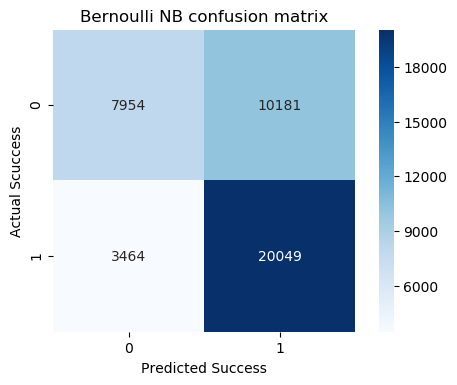

In [90]:
# Print confusion matrix on the test-set
bernoulli_confusion = confusion_matrix(y_test, bernoulli.predict(X_test))
plt.figure(dpi=100)
sns.heatmap(bernoulli_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')

plt.xlabel('Predicted Success')
plt.ylabel('Actual Scuccess')
plt.title('Bernoulli NB confusion matrix');


# xgBoost

In [53]:
xgBoost = XGBClassifier()

In [54]:
xgBoost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [55]:
xgBoost_pred = xgBoost.predict(X_val)
xgBoost_y_score = xgBoost.predict_proba(X_val)[:,1]

In [56]:
xgBoost_fpr, xgBoost_tpr, exBoost_thresholds = roc_curve(y_val, xgBoost_y_score)
roc_auc_xgBoost = auc(xgBoost_fpr, xgBoost_tpr)

In [57]:
print(auc(xgBoost_fpr, xgBoost_tpr))

0.7982350355198568


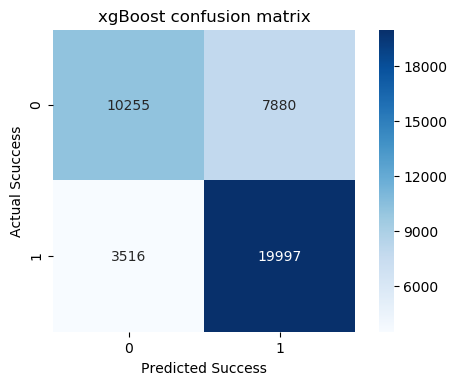

In [91]:
# Print confusion matrix on the test-set
xgBoost_confusion = confusion_matrix(y_test, xgBoost.predict(X_test))
plt.figure(dpi=100)
sns.heatmap(xgBoost_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')

plt.xlabel('Predicted Success')
plt.ylabel('Actual Scuccess')
plt.title('xgBoost confusion matrix');


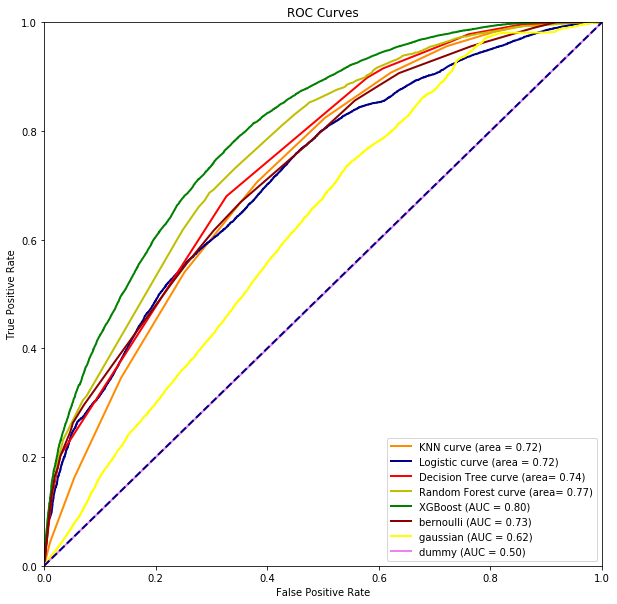

In [101]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(knn_fpr, knn_tpr, color='darkorange',
         lw=lw, label='KNN curve (area = %0.2f)' % roc_auc_knn)
plt.plot(logit_fpr, logit_tpr, color='darkblue',
         lw=lw, label='Logistic curve (area = %0.2f)' % roc_auc_logit)
plt.plot(tree_fpr, tree_tpr, color='r',
        lw=lw, label ='Decision Tree curve (area= %0.2f)' %roc_auc_tree)
plt.plot(forest_fpr, forest_tpr, color='y',
        lw=lw, label ='Random Forest curve (area= %0.2f)' %roc_auc_forest)
plt.plot(xgBoost_fpr, xgBoost_tpr, color='green',
         lw=lw, label='XGBoost (AUC = %0.2f)' % roc_auc_xgBoost)
plt.plot(bernoulli_fpr, bernoulli_tpr, color='darkred',
         lw=lw, label='bernoulli (AUC = %0.2f)' % roc_auc_bernoulli)
plt.plot(gaussian_fpr, gaussian_tpr, color='yellow',
         lw=lw, label='gaussian (AUC = %0.2f)' % roc_auc_gaussian)
plt.plot(Dummy_fpr, Dummy_tpr, color='violet',
         lw=lw, label='dummy (AUC = %0.2f)' % roc_auc_Dummy)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

now that we have all of the model and the confusion matrix we can build a dummy base variable
to see what the dummiest result can be!!!

# Dummy base line

In [93]:
from sklearn.dummy import DummyClassifier
Dummy = DummyClassifier()
Dummy.fit(X_train, y_train)
Dummy_pred = Dummy.predict(X_val)

In [95]:
print('Dummy Results:')
print(confusion_matrix(y_val, Dummy_pred))
print(classification_report(y_val, Dummy_pred))
print('score: %f' % Dummy.fit(X_train, y_train).score(X_val, y_val))

Dummy Results:
[[ 8008 10103]
 [10229 13308]]
              precision    recall  f1-score   support

           0       0.44      0.44      0.44     18111
           1       0.57      0.57      0.57     23537

   micro avg       0.51      0.51      0.51     41648
   macro avg       0.50      0.50      0.50     41648
weighted avg       0.51      0.51      0.51     41648

score: 0.510085


In [96]:
Dummy_y_score = Dummy.predict_proba(X_val)[:, 1]

In [100]:
Dummy_fpr, Dummy_tpr, auc_thresholds = roc_curve(y_val, Dummy_y_score)
roc_auc_Dummy = auc(Dummy_fpr, Dummy_tpr)
print(auc(Dummy_fpr, Dummy_tpr))

0.4994309496277396


# Optimizing for Precision Experiment with XGBoost

In [118]:
y_probs = xgBoost.predict_proba(X_test)[:, 1]
precisions = []
thresholds = []
for t in range(0,100,5):
    y_pred = pd.Series(y_probs).apply(lambda x: 0 if x<(t/100) else 1)
    precisions.append(metrics.precision_score(y_test, y_pred))
    thresholds.append(t/100)

In [119]:
np.argmax(np.array(precisions))

19

In [120]:
thresholds[19]

0.95

In [121]:
max(precisions)

0.967741935483871

In [122]:
y_pred_precise = pd.Series(y_probs).apply(lambda x: 0 if x<(95/100) else 1)

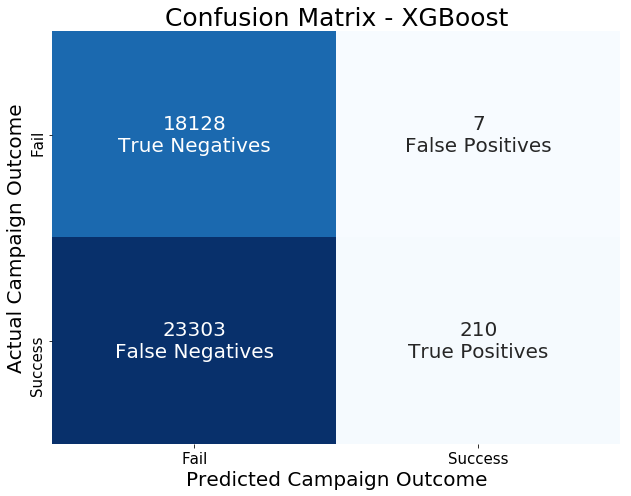

In [123]:
cm = confusion_matrix(y_test,y_pred_precise)
plt.figure(figsize=(25,7))
plt.subplot(131)
ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, 
                annot_kws={"size": 20}, fmt='g')
cmlabels = ['True Negatives', 'False Positives',
              'False Negatives', 'True Positives']
for i,t in enumerate(ax.texts):
    t.set_text(t.get_text() + "\n" + cmlabels[i])
plt.title('Confusion Matrix - XGBoost', size=25)
plt.xlabel('Predicted Campaign Outcome', size=20)
plt.ylabel('Actual Campaign Outcome', size=20)
labels = ['Fail', 'Success']
ax.set_xticklabels(labels, size = 15)
ax.set_yticklabels(labels, size = 15)
plt.tight_layout()
plt.show()

# Feature Importance using XGBoost

In [125]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15,15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [126]:
xgBoost = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [127]:
feature_gboost = xgb.DMatrix(X, label=y)

In [130]:
feature_gboost.feature_names

['goal',
 'length_blurb',
 'staff_pick_True',
 'campaign_lenght_days',
 'sub_category_art',
 'sub_category_comics',
 'sub_category_crafts',
 'sub_category_dance',
 'sub_category_design',
 'sub_category_fashion',
 'sub_category_film & video',
 'sub_category_food',
 'sub_category_games',
 'sub_category_journalism',
 'sub_category_music',
 'sub_category_photography',
 'sub_category_publishing',
 'sub_category_technology',
 'sub_category_theater']

In [83]:
d = xgb.train(params,feature_gboost)

[13:52:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[13:52:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[13:52:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[13:52:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[13:52:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[13:52:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[13:52:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[13:52:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[13:52:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nod

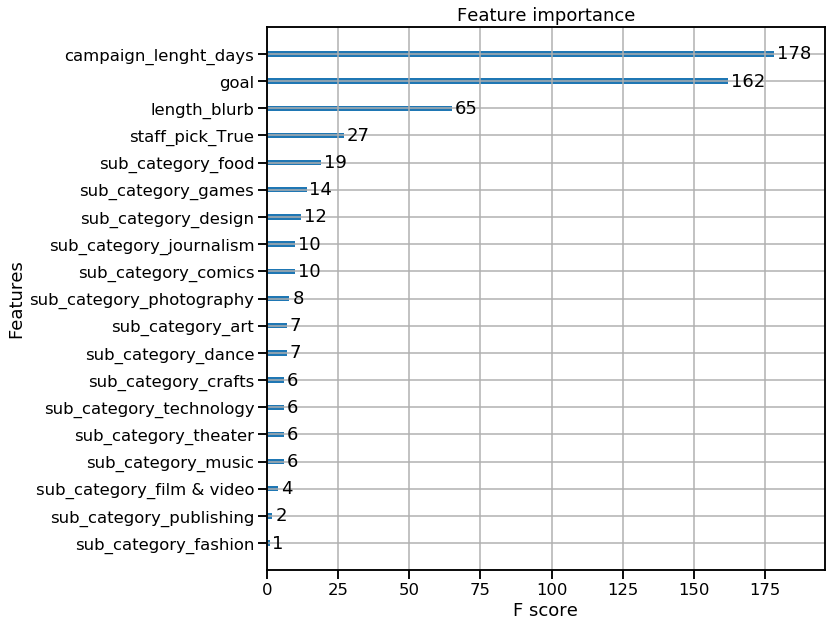

In [84]:
sns.set_context('talk')
fig, ax = plt.subplots(1, 1, figsize=(10,10))
xgb.plot_importance(d, max_num_features=30, ax=ax);

In [131]:
xgBoost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

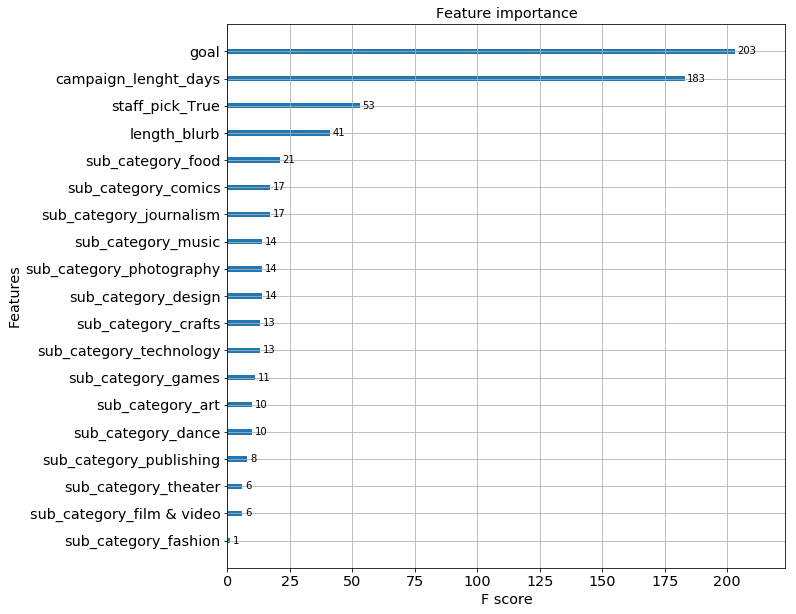

In [132]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(xgBoost, max_num_features=30, ax=ax)

In [71]:
X_train_sc

array([[-2.44835305e-04,  1.38738930e+00, -3.83901686e-01, ...,
        -3.26181365e-01, -3.37432744e-01, -1.83217949e-01],
       [-3.90840988e-02,  8.02300654e-01, -3.83901686e-01, ...,
        -3.26181365e-01, -3.37432744e-01, -1.83217949e-01],
       [-3.50498779e-02,  1.38738930e+00, -3.83901686e-01, ...,
         3.06577906e+00, -3.37432744e-01, -1.83217949e-01],
       ...,
       [-3.42588542e-02, -5.62906190e-01, -3.83901686e-01, ...,
        -3.26181365e-01, -3.37432744e-01, -1.83217949e-01],
       [-3.38633424e-02,  2.21824571e-02, -3.83901686e-01, ...,
        -3.26181365e-01, -3.37432744e-01, -1.83217949e-01],
       [-3.74229490e-02, -1.53805394e+00, -3.83901686e-01, ...,
        -3.26181365e-01, -3.37432744e-01, -1.83217949e-01]])

In [51]:
conda install -c conda-forge shap

Solving environment: done

## Package Plan ##

  environment location: /Users/fahimehkhaleghi/anaconda3

  added / updated specs:
    - shap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    shap-0.29.3                |   py37h86efe34_0         307 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         307 KB

The following NEW packages will be INSTALLED:

  shap               conda-forge/osx-64::shap-0.29.3-py37h86efe34_0



shap-0.29.3          | 307 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done

Note: you may need to restart the kernel to use updated packages.


In [134]:
import shap
import xgboost

In [135]:
shap.initjs()

In [136]:
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
#shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

[23:39:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[23:39:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[23:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[23:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[23:39:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[23:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[23:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[23:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[23:39:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned no

[23:40:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[23:40:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[23:40:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[23:40:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[23:40:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[23:40:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[23:40:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[23:40:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[23:40:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned no

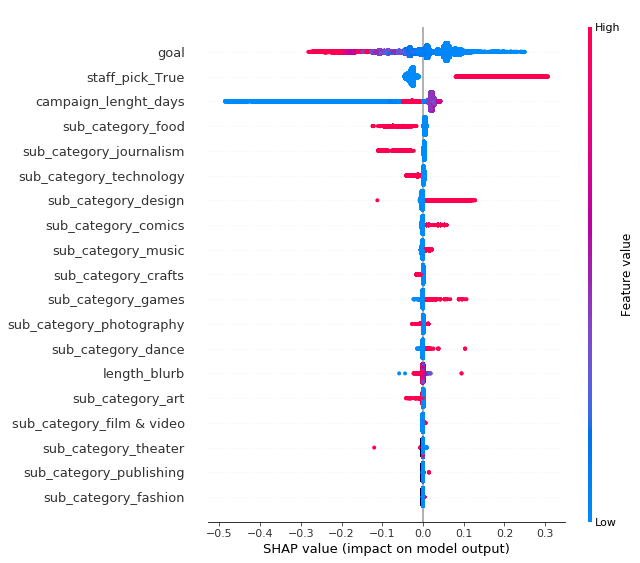

In [137]:
feature_names = ['goal', 'length_blurb','staff_pick_True','campaign_lenght_days','sub_category_art',
       'sub_category_comics', 'sub_category_crafts', 'sub_category_dance',
       'sub_category_design', 'sub_category_fashion',
       'sub_category_film & video', 'sub_category_food', 'sub_category_games',
       'sub_category_journalism', 'sub_category_music',
       'sub_category_photography', 'sub_category_publishing',
       'sub_category_technology', 'sub_category_theater']

plt.figure(figsize=(20,20))
plt.tight_layout()

trace = shap.summary_plot(shap_values, X, feature_names = feature_names, show = False)
#plt.savefig('shap_feature_importance.svg')
#plt.savefig('shap_feature_importance.png')

In [138]:
layout = go.Layout(title="Feature importances")
fig = go.Figure(data = trace, layout=layout)

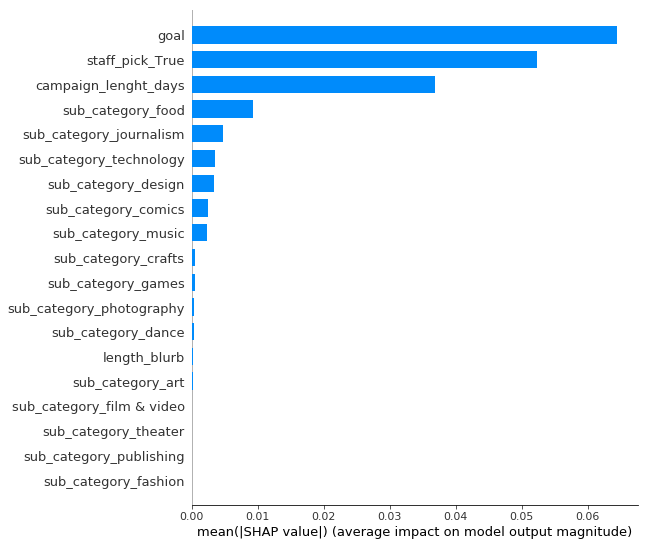

In [139]:
shap.summary_plot(shap_values, X, plot_type="bar")